# Finetuning FakeNewsAAAI
FakeNewsAAAI is a Fake News dataset with 2 possible labels: `real` and `fake`

In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.multiprocessing as mp
from tqdm import tqdm
import pickle
from copy import deepcopy
from multiprocessing import Pool                                                

from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from utils.forward_fn import forward_mask_sequence_classification
from utils.metrics import classification_metrics_fn
from utils.data_utils import FakeNewsDataset, FakeNewsDataLoader
from utils.utils import generate_random_mask

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [3]:
# Set random seed
set_seed(26092020)

# Set mp start method
mp.set_start_method('spawn')

# Load Model

In [4]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
config = AutoConfig.from_pretrained('roberta-base')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [5]:
count_param(model)

124647170

# Prepare Dataset

In [6]:
train_dataset_path = './data/train.tsv'
valid_dataset_path = './data/valid.tsv'
# test_dataset_path = './dataset/test.tsv'

In [7]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)
# test_dataset = FakeNewsDataset(dataset_path=test_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)  
# test_loader = FakeNewsDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)

In [8]:
w2i, i2w = FakeNewsDataset.LABEL2INDEX, FakeNewsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'fake': 0, 'real': 1}
{0: 'fake', 1: 'real'}


# Fine Tuning & Evaluation

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)
model = model.cuda()

In [10]:
# Train
n_epochs = 1
best_val_metric, best_metrics, best_state_dict = 0, None, None
early_stop, count_stop = 3, 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    if best_val_metric <= val_metric:
        best_state_dict = model.state_dict().copy()
        best_val_metric = val_metric
        best_metrics = metrics
        count_stop = 0
    else:
        count_stop += 1
        if count_stop == early_stop:
            break
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

# Save best model
for k, v in best_state_dict.items():
    best_state_dict[k] = v.cpu()
torch.save(best_state_dict, './tmp/model_weight.pt')

# Load best model
model.load_state_dict(best_state_dict)

  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.5570 ACC:0.6823 F1:0.6697 REC:0.6746 PRE:0.6975 LR:0.00000100


VALID LOSS:0.2080 ACC:0.9158 F1:0.9157 REC:0.9161 PRE:0.9155: 100%|██████████| 268/268 [00:38<00:00,  6.94it/s]


(Epoch 1) VALID LOSS:0.2080 ACC:0.9158 F1:0.9157 REC:0.9161 PRE:0.9155
== BEST METRICS ==
ACC:0.9158 F1:0.9157 REC:0.9161 PRE:0.9155


<All keys matched successfully>

In [11]:
# # Evaluate on test
# model.eval()
# torch.set_grad_enabled(False)

# total_loss, total_correct, total_labels = 0, 0, 0
# list_hyp, list_label = [], []

# pbar = tqdm(test_loader, leave=True, total=len(test_loader))
# for i, batch_data in enumerate(pbar):
#     _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
#     list_hyp += batch_hyp

# # Save prediction
# df = pd.DataFrame({'label':list_hyp}).reset_index()
# df.index = df.index + 1
# df.to_csv('prediction.csv')

# print(df)

# Calculate Influence

In [12]:
def influence_score(model, id, subword, mask, label, device='cpu'):
    loss_fct = CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        # Prepare input & label
        subword = torch.LongTensor(subword)
        mask = torch.FloatTensor(mask)
        label = torch.LongTensor(label)

        if device == "cuda":
            subword = subword.cuda()
            mask = mask.cuda()
            label = label.cuda()

        if isinstance(model, BertForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.weight, model.classifier.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.bert(subword, attention_mask=mask)[1]
            latents = model.dropout(latents)            
        elif isinstance(model, RobertaForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.out_proj.weight, model.classifier.out_proj.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.roberta(subword, attention_mask=mask)[0][:,0,:]
            latents = model.classifier.dense(latents)
            latents = model.classifier.dropout(latents)
        else:
            ValueError(f'Model class `{type(model)}` is not implemented yet')

        # Compute loss with mask
        logits = torch.einsum('bd,bcd->bc', latents, masked_weight) + bias
        mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))

        # Compute loss with flipped mask
        logits = torch.einsum('bd,bcd->bc', latents, (masked_weight.max() - masked_weight)) + bias
        flipped_mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))
                              
        return flipped_mask_loss - mask_loss
                              
def build_influence_matrix(model, data_loader, train_size, device='cpu'):
    test_size, batch_size = len(data_loader.dataset), data_loader.batch_size
    influence_mat = torch.zeros(test_size, train_size, device=device)
    idx2id = {}
    for i, batch_data in enumerate(data_loader):
        print(f'Processing batch {i+1}/{len(data_loader)}')
        (ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data
        token_type_batch = None

        for train_idx in tqdm(range(train_size)):
            train_id = train_idx + 1
            scores = influence_score(model, train_id, subword_batch, mask_batch, label_batch, device=device)
            for j, id in enumerate(ids):
                idx2id[(i * batch_size) + j] = id
                influence_mat[(i * batch_size) + j, train_idx] = scores[j]
    return influence_mat, idx2id

def get_inference_result(model, data_loader, device='cpu'):
    results = {}
    with torch.no_grad():
        pbar = tqdm(data_loader, leave=True, total=len(data_loader))
        for i, batch_data in enumerate(pbar):
            batch_id = batch_data[0]
            batch_seq = batch_data[-1]
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            for i, id in enumerate(batch_id):
                results[id] = batch_hyp[i] == batch_label[i]
    return results

def get_filtered_dataloader(data_loader, id_list, inclusive=True, batch_size=8, shuffle=False):
    df = data_loader.dataset.data
    if inclusive:
        filt_df = df[df['id'].isin(id_list)].reset_index(drop=True)
    else:
        filt_df = df[~df['id'].isin(id_list)].reset_index(drop=True)
    dataset = FakeNewsDataset(dataset_path=None, dataset=filt_df, tokenizer=tokenizer, lowercase=False)
    data_loader = FakeNewsDataLoader(dataset=dataset, max_seq_len=512, batch_size=batch_size, num_workers=8, shuffle=shuffle)  
    return data_loader

# Influence score on incorrectly classified data

In [ ]:
%%time
(ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data
influence_score(model, ids[0], subword_batch, mask_batch, label_batch, device='cuda')

In [ ]:
%%time
results = get_inference_result(model, valid_loader, device='cuda')
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

In [ ]:
filt_valid_loader = get_filtered_dataloader(valid_loader, incorrect_list, batch_size=16)
len(valid_loader), len(filt_valid_loader), len(valid_loader.dataset), len(filt_valid_loader.dataset)

In [ ]:
%%time
influence_matrix, idx2id = build_influence_matrix(model, filt_valid_loader, len(train_loader.dataset), device='cuda')

In [ ]:
np.save('influence_matrix.npy', (influence_matrix, idx2id))

# Influence score on all validation data

In [24]:
# Save data per chunk to file
n_chunks = 6
chunk_size = (valid_loader.dataset.data.shape[0] // n_chunks) + 1
chunk_data, models = [], []

df = pd.read_csv('./data/valid.tsv', sep='\t')
for i in range(n_chunks):
    df.loc[i * chunk_size:(i+1) * chunk_size,:].to_csv(f'./tmp/chunk_{i}.tsv', sep='\t', index=False)

In [25]:
# # NOT SURE WHY IT IS NOT WORKING
# # Process chunk in parallel
# processes = (
#     'CUDA_VISIBLE_DEVICES=1 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_0.tsv --model_path ./tmp/model_weight.pt --index 0 > log_0.log', 
#     'CUDA_VISIBLE_DEVICES=2 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_1.tsv --model_path ./tmp/model_weight.pt --index 1 > log_1.log', 
#     'CUDA_VISIBLE_DEVICES=3 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_2.tsv --model_path ./tmp/model_weight.pt --index 2 > log_2.log', 
#     'CUDA_VISIBLE_DEVICES=4 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_3.tsv --model_path ./tmp/model_weight.pt --index 3 > log_3.log', 
#     'CUDA_VISIBLE_DEVICES=5 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_4.tsv --model_path ./tmp/model_weight.pt --index 4 > log_4.log', 
#     'CUDA_VISIBLE_DEVICES=6 /home/samuel/anaconda2/envs/env_py3.7/bin/python build_influence_matrix.py --valid_dataset_path ./tmp/chunk_5.tsv --model_path ./tmp/model_weight.pt --index 5 > log_5.log'
# )

# def run_process(process):
#     os.system(process)

# pool = Pool(processes=6)
# pool.map(run_process, processes)

In [ ]:
# Aggregate result
influence_matrices, idx2ids = [], []
for i in range(6):
    (influence_matrix, idx2id) = np.load(f"./tmp/influence_matrix_{i}.npy")
    influence_matrices.append(influence_matrix)
    idx2ids.append(idx2id)

In [18]:
np.save('influence_matrix_all.npy', (influence_matrix, idx2id))

# Analyse influence

In [9]:
(influence_matrix, idx2id) = np.load('influence_matrix.npy', allow_pickle=True)

In [20]:
train_df = train_loader.dataset.data
valid_df = valid_loader.dataset.data

In [18]:
for id, tid in zip(idx2id.values(), influence_matrix.argmin(dim=-1).cpu().numpy()):
    valid_df.loc[valid_df['id'] == id, 'tid'] = tid

In [28]:
filt_valid_df = valid_df[valid_df['id'].isin(idx2id.values())]
train_df.columns = ['tid','t_tweet', 't_label']

train_df['ts_tweet'] = train_df['t_tweet'].apply(lambda x: tokenizer.tokenize(x))
filt_valid_df['s_tweet'] = filt_valid_df['tweet'].apply(lambda x: tokenizer.tokenize(x))

merged_df = filt_valid_df.merge(train_df, on='tid', how='inner')

/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [49]:
merged_df['matched_subwords'] = merged_df.apply(lambda row: list(set(row['s_tweet']).intersection(set(row['ts_tweet']))), axis='columns')

In [52]:
import json
json.dump(merged_df[['tweet', 't_tweet', 's_tweet', 'ts_tweet', 'matched_subwords']].to_dict(orient='instance'), open('merged.json', 'w'))

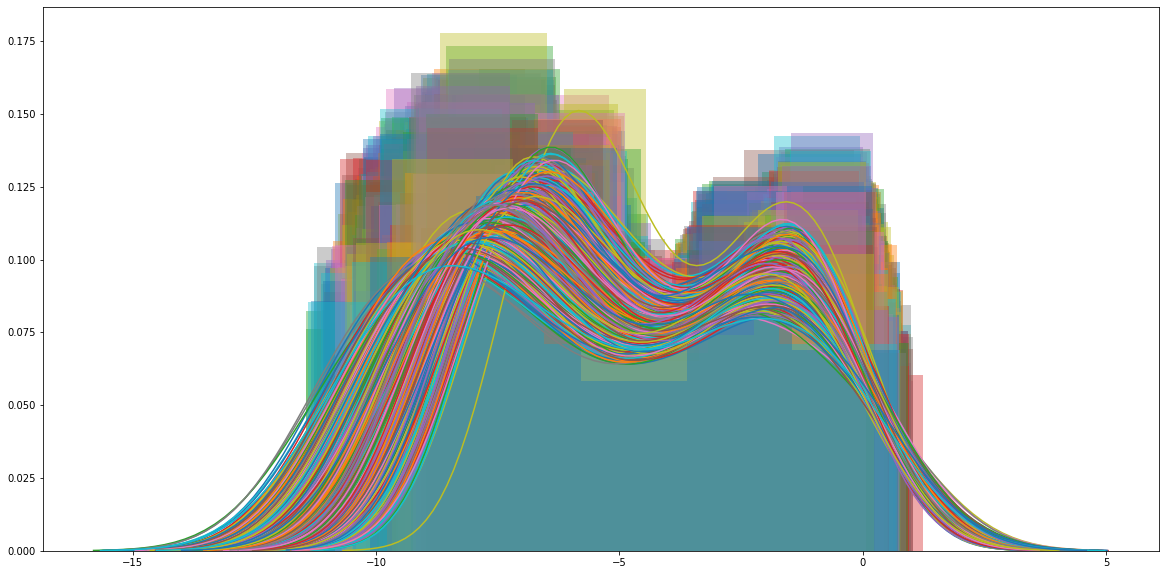

In [20]:
plt.figure(figsize=(20,10))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i].cpu().numpy(), ax=ax)
    if i == 1500:
        break
plt.savefig('influence_dist.png')
plt.show()

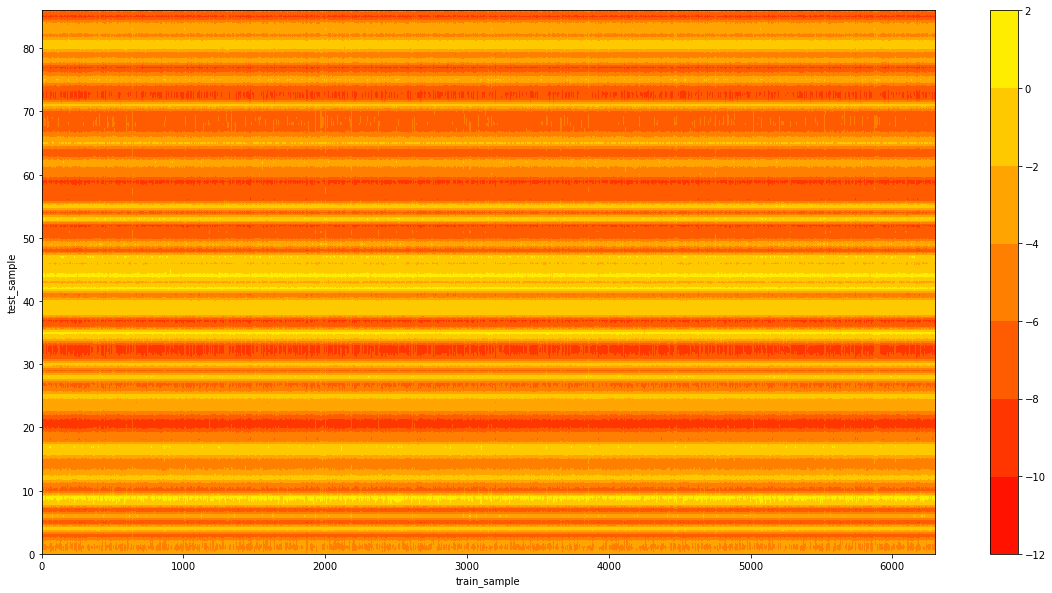

In [21]:
plt.figure(figsize=(20,10))
mat = influence_matrix.cpu().numpy()
plt.contourf(mat, cmap='autumn')
plt.colorbar()
plt.xlabel('train_sample')
plt.ylabel('test_sample')
plt.savefig('influence.png')
plt.show()

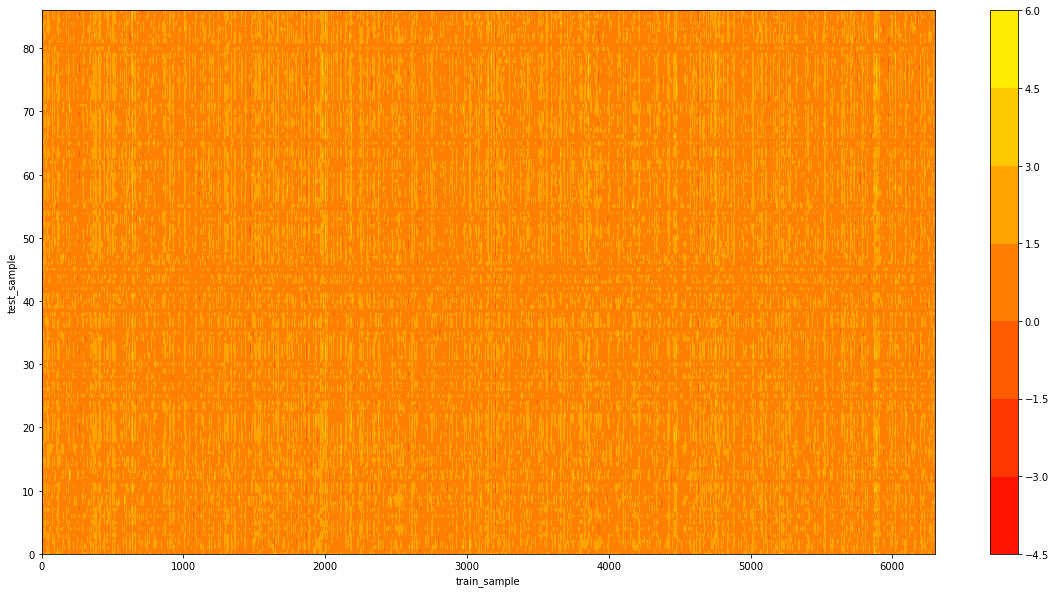

In [22]:
plt.figure(figsize=(20,10))
mat = influence_matrix.cpu().numpy()
mat = (mat - mat.mean(axis=-1, keepdims=True)) / mat.std(axis=-1, keepdims=True)
plt.contourf(mat, cmap='autumn')
plt.colorbar()
plt.xlabel('train_sample')
plt.ylabel('test_sample')
plt.savefig('influence_norm.png')
plt.show()

# Data cleansing

In [23]:
values, indices = influence_matrix.sum(dim=0).sort()

In [24]:
n_elmt = indices.shape[0]
percentages = np.arange(0, 1, 0.01) + 0.01
index_percent_list = {f'{np.round(p, 2):.2f}' : indices[:int(n_elmt / (1 / p))] for p in percentages}

In [25]:
pickle.dump(index_percent_list, open('index_percent_list.pkl','wb'))

# Retraining per percentage

In [10]:
index_percent_list = pickle.load(open('index_percent_list.pkl','rb'))

In [11]:
[(k, len(v)) for k,v in index_percent_list.items()]

[('0.01', 62),
 ('0.02', 125),
 ('0.03', 188),
 ('0.04', 251),
 ('0.05', 314),
 ('0.06', 377),
 ('0.07', 440),
 ('0.08', 503),
 ('0.09', 566),
 ('0.10', 629),
 ('0.11', 692),
 ('0.12', 755),
 ('0.13', 818),
 ('0.14', 881),
 ('0.15', 944),
 ('0.16', 1007),
 ('0.17', 1070),
 ('0.18', 1133),
 ('0.19', 1196),
 ('0.20', 1259),
 ('0.21', 1322),
 ('0.22', 1385),
 ('0.23', 1448),
 ('0.24', 1511),
 ('0.25', 1574),
 ('0.26', 1637),
 ('0.27', 1700),
 ('0.28', 1763),
 ('0.29', 1826),
 ('0.30', 1889),
 ('0.31', 1952),
 ('0.32', 2015),
 ('0.33', 2078),
 ('0.34', 2141),
 ('0.35', 2204),
 ('0.36', 2267),
 ('0.37', 2330),
 ('0.38', 2393),
 ('0.39', 2456),
 ('0.40', 2519),
 ('0.41', 2582),
 ('0.42', 2645),
 ('0.43', 2708),
 ('0.44', 2771),
 ('0.45', 2834),
 ('0.46', 2897),
 ('0.47', 2960),
 ('0.48', 3023),
 ('0.49', 3086),
 ('0.50', 3149),
 ('0.51', 3212),
 ('0.52', 3275),
 ('0.53', 3338),
 ('0.54', 3401),
 ('0.55', 3464),
 ('0.56', 3527),
 ('0.57', 3590),
 ('0.58', 3653),
 ('0.59', 3716),
 ('0.60', 377

In [12]:
stat_results = {}
for percentage in [0.01, 0.02, 0.05, 0.10, 0.25]:
    filt_indices = index_percent_list[f'{percentage:.2f}']
    print(f'== Retraining with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) ==')
    
    # Set random seed
    set_seed(26092020)
    
    # Load Tokenizer and Config
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    config = AutoConfig.from_pretrained('roberta-base')
    config.num_labels = FakeNewsDataset.NUM_LABELS

    # Instantiate model
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)
    
    # Data Loader
    filt_train_loader = get_filtered_dataloader(train_loader, filt_indices, inclusive=False, batch_size=8, shuffle=True)
    
    # Prepare for training
    optimizer = optim.Adam(model.parameters(), lr=1e-6)
    model = model.cuda()
    
    # Train
    n_epochs = 10
    best_val_metric, best_metrics = 0, None
    early_stop, count_stop = 3, 0
    for epoch in range(n_epochs):
        model.train()
        torch.set_grad_enabled(True)

        total_train_loss = 0
        list_hyp, list_label = [], []

        train_pbar = tqdm(train_loader, leave=True, total=len(filt_train_loader))
        for i, batch_data in enumerate(train_pbar):
            # Forward model
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss = loss.item()
            total_train_loss = total_train_loss + tr_loss

            # Calculate metrics
            list_hyp += batch_hyp
            list_label += batch_label

            train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
                total_train_loss/(i+1), get_lr(optimizer)))

        # Calculate train metric
        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
        
        # Evaluate on validation
        model.eval()
        torch.set_grad_enabled(False)

        total_loss, total_correct, total_labels = 0, 0, 0
        list_hyp, list_label = [], []

        pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
        for i, batch_data in enumerate(pbar):
            batch_seq = batch_data[-1]        
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            metrics = classification_metrics_fn(list_hyp, list_label)

            pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

        metrics = classification_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
            total_loss/(i+1), metrics_to_string(metrics)))

        # Early stopping
        val_metric = metrics['F1']
        if best_val_metric < val_metric:
            best_val_metric = val_metric
            best_metrics = metrics
            count_stop = 0
        else:
            count_stop += 1
            if count_stop == early_stop:
                break
    print(f'Evaluation with {percentage * 100}% cleansing (remove {len(filt_indices)} samples) {metrics_to_string(best_metrics)}')
    stat_results[percentage] = best_metrics
    
for p, metrics in stat_result.item():
    print(f'{p * 100}% cleansing (remove {len(filt_indices)} samples) | {metrics_to_string(best_metrics)}')

== Retraining with 1.0% cleansing (remove 62 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.5717 ACC:0.6692 F1:0.6479 REC:0.6590 PRE:0.6975 LR:0.00000100


VALID LOSS:0.2289 ACC:0.9125 F1:0.9117 REC:0.9100 PRE:0.9157:  74%|███████▍  | 198/268 [00:07<00:02, 24.96it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.2393 ACC:0.9060 F1:0.9053 REC:0.9040 PRE:0.9093: 100%|██████████| 268/268 [00:10<00:00, 25.73it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.2393 ACC:0.9060 F1:0.9053 REC:0.9040 PRE:0.9093


(Epoch 2) TRAIN LOSS:0.1731 LR:0.00000100:  86%|████████▋ | 673/780 [01:11<00:11,  9.01it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 2) TRAIN LOSS:0.1722 LR:0.00000100: : 788it [01:23,  9.39it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.1722 ACC:0.9401 F1:0.9400 REC:0.9400 PRE:0.9400 LR:0.00000100


VALID LOSS:0.1307 ACC:0.9475 F1:0.9471 REC:0.9456 PRE:0.9499:  74%|███████▍  | 199/268 [00:07<00:02, 25.49it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1401 ACC:0.9448 F1:0.9445 REC:0.9435 PRE:0.9469: 100%|██████████| 268/268 [00:10<00:00, 26.33it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1401 ACC:0.9448 F1:0.9445 REC:0.9435 PRE:0.9469


(Epoch 3) TRAIN LOSS:0.0844 LR:0.00000100:  86%|████████▋ | 673/780 [01:12<00:11,  9.03it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 3) TRAIN LOSS:0.0876 LR:0.00000100: : 788it [01:24,  9.37it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0876 ACC:0.9743 F1:0.9742 REC:0.9742 PRE:0.9743 LR:0.00000100


VALID LOSS:0.1108 ACC:0.9619 F1:0.9617 REC:0.9612 PRE:0.9623:  74%|███████▍  | 199/268 [00:07<00:02, 24.87it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1195 ACC:0.9570 F1:0.9569 REC:0.9565 PRE:0.9574: 100%|██████████| 268/268 [00:10<00:00, 25.94it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1195 ACC:0.9570 F1:0.9569 REC:0.9565 PRE:0.9574


(Epoch 4) TRAIN LOSS:0.0472 LR:0.00000100:  86%|████████▋ | 673/780 [01:11<00:11,  9.03it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 4) TRAIN LOSS:0.0497 LR:0.00000100: : 788it [01:24,  9.38it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0497 ACC:0.9883 F1:0.9882 REC:0.9881 PRE:0.9883 LR:0.00000100


VALID LOSS:0.1093 ACC:0.9637 F1:0.9636 REC:0.9635 PRE:0.9637:  74%|███████▍  | 199/268 [00:07<00:02, 24.65it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1184 ACC:0.9603 F1:0.9602 REC:0.9601 PRE:0.9603: 100%|██████████| 268/268 [00:10<00:00, 25.56it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1184 ACC:0.9603 F1:0.9602 REC:0.9601 PRE:0.9603


(Epoch 5) TRAIN LOSS:0.0255 LR:0.00000100:  86%|████████▋ | 673/780 [01:11<00:11,  9.04it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 5) TRAIN LOSS:0.0273 LR:0.00000100: : 788it [01:24,  9.38it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0273 ACC:0.9941 F1:0.9941 REC:0.9941 PRE:0.9941 LR:0.00000100


VALID LOSS:0.1125 ACC:0.9644 F1:0.9642 REC:0.9639 PRE:0.9646:  75%|███████▍  | 200/268 [00:07<00:02, 24.87it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1232 ACC:0.9589 F1:0.9587 REC:0.9585 PRE:0.9591: 100%|██████████| 268/268 [00:10<00:00, 25.92it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1232 ACC:0.9589 F1:0.9587 REC:0.9585 PRE:0.9591


(Epoch 6) TRAIN LOSS:0.0127 LR:0.00000100:  86%|████████▋ | 673/780 [01:13<00:13,  8.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 6) TRAIN LOSS:0.0132 LR:0.00000100: : 788it [01:26,  9.08it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0132 ACC:0.9973 F1:0.9973 REC:0.9973 PRE:0.9973 LR:0.00000100


VALID LOSS:0.1319 ACC:0.9637 F1:0.9635 REC:0.9627 PRE:0.9647:  75%|███████▍  | 200/268 [00:07<00:02, 25.46it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1463 ACC:0.9589 F1:0.9587 REC:0.9581 PRE:0.9597: 100%|██████████| 268/268 [00:10<00:00, 26.22it/s]
  0%|          | 0/780 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1463 ACC:0.9589 F1:0.9587 REC:0.9581 PRE:0.9597


(Epoch 7) TRAIN LOSS:0.0054 LR:0.00000100:  86%|████████▋ | 673/780 [01:14<00:11,  9.06it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 7) TRAIN LOSS:0.0058 LR:0.00000100: : 788it [01:26,  9.11it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0058 ACC:0.9994 F1:0.9994 REC:0.9993 PRE:0.9994 LR:0.00000100


VALID LOSS:0.1559 ACC:0.9606 F1:0.9604 REC:0.9593 PRE:0.9620:  74%|███████▍  | 199/268 [00:07<00:02, 25.24it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1742 ACC:0.9556 F1:0.9554 REC:0.9546 PRE:0.9569: 100%|██████████| 268/268 [00:10<00:00, 25.65it/s]


(Epoch 7) VALID LOSS:0.1742 ACC:0.9556 F1:0.9554 REC:0.9546 PRE:0.9569
Evaluation with 1.0% cleansing (remove 62 samples) ACC:0.9603 F1:0.9602 REC:0.9601 PRE:0.9603
== Retraining with 2.0% cleansing (remove 125 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.5239 ACC:0.7044 F1:0.6964 REC:0.6983 PRE:0.7142 LR:0.00000100


VALID LOSS:0.1861 ACC:0.9256 F1:0.9248 REC:0.9229 PRE:0.9298:  74%|███████▍  | 199/268 [00:07<00:02, 25.23it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1947 ACC:0.9205 F1:0.9199 REC:0.9183 PRE:0.9249: 100%|██████████| 268/268 [00:10<00:00, 25.70it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1947 ACC:0.9205 F1:0.9199 REC:0.9183 PRE:0.9249


(Epoch 2) TRAIN LOSS:0.1466 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:11,  9.01it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 2) TRAIN LOSS:0.1466 LR:0.00000100: : 788it [01:24,  9.33it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.1466 ACC:0.9457 F1:0.9456 REC:0.9455 PRE:0.9456 LR:0.00000100


VALID LOSS:0.1230 ACC:0.9556 F1:0.9554 REC:0.9549 PRE:0.9560:  75%|███████▍  | 200/268 [00:07<00:02, 25.33it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1299 ACC:0.9523 F1:0.9522 REC:0.9517 PRE:0.9528: 100%|██████████| 268/268 [00:10<00:00, 26.06it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1299 ACC:0.9523 F1:0.9522 REC:0.9517 PRE:0.9528


(Epoch 3) TRAIN LOSS:0.0774 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:11,  9.06it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 3) TRAIN LOSS:0.0798 LR:0.00000100: : 788it [01:25,  9.24it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0798 ACC:0.9760 F1:0.9760 REC:0.9760 PRE:0.9760 LR:0.00000100


VALID LOSS:0.1134 ACC:0.9594 F1:0.9592 REC:0.9588 PRE:0.9597:  74%|███████▍  | 199/268 [00:07<00:02, 25.35it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1216 ACC:0.9551 F1:0.9550 REC:0.9546 PRE:0.9555: 100%|██████████| 268/268 [00:10<00:00, 26.08it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1216 ACC:0.9551 F1:0.9550 REC:0.9546 PRE:0.9555


(Epoch 4) TRAIN LOSS:0.0445 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:11,  8.96it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 4) TRAIN LOSS:0.0454 LR:0.00000100: : 788it [01:24,  9.30it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0454 ACC:0.9886 F1:0.9885 REC:0.9885 PRE:0.9885 LR:0.00000100


VALID LOSS:0.1124 ACC:0.9637 F1:0.9636 REC:0.9634 PRE:0.9638:  75%|███████▍  | 200/268 [00:07<00:02, 24.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1224 ACC:0.9575 F1:0.9573 REC:0.9570 PRE:0.9577: 100%|██████████| 268/268 [00:10<00:00, 25.14it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1224 ACC:0.9575 F1:0.9573 REC:0.9570 PRE:0.9577


(Epoch 5) TRAIN LOSS:0.0248 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:11,  9.00it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 5) TRAIN LOSS:0.0244 LR:0.00000100: : 788it [01:24,  9.30it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0244 ACC:0.9943 F1:0.9943 REC:0.9943 PRE:0.9943 LR:0.00000100


VALID LOSS:0.1273 ACC:0.9650 F1:0.9648 REC:0.9639 PRE:0.9661:  75%|███████▍  | 200/268 [00:07<00:02, 25.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1405 ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609: 100%|██████████| 268/268 [00:10<00:00, 25.96it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1405 ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609


(Epoch 6) TRAIN LOSS:0.0133 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:12,  8.22it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 6) TRAIN LOSS:0.0122 LR:0.00000100: : 788it [01:25,  9.25it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0122 ACC:0.9979 F1:0.9979 REC:0.9979 PRE:0.9979 LR:0.00000100


VALID LOSS:0.1450 ACC:0.9613 F1:0.9610 REC:0.9600 PRE:0.9626:  75%|███████▍  | 200/268 [00:07<00:02, 24.87it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1613 ACC:0.9561 F1:0.9559 REC:0.9550 PRE:0.9574: 100%|██████████| 268/268 [00:10<00:00, 26.04it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1613 ACC:0.9561 F1:0.9559 REC:0.9550 PRE:0.9574


(Epoch 7) TRAIN LOSS:0.0077 LR:0.00000100:  87%|████████▋ | 673/773 [01:13<00:12,  8.25it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 7) TRAIN LOSS:0.0070 LR:0.00000100: : 788it [01:26,  9.15it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0070 ACC:0.9989 F1:0.9989 REC:0.9989 PRE:0.9989 LR:0.00000100


VALID LOSS:0.1565 ACC:0.9637 F1:0.9635 REC:0.9625 PRE:0.9651:  74%|███████▍  | 199/268 [00:07<00:02, 24.97it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1731 ACC:0.9575 F1:0.9573 REC:0.9565 PRE:0.9588: 100%|██████████| 268/268 [00:10<00:00, 25.68it/s]
  0%|          | 0/773 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1731 ACC:0.9575 F1:0.9573 REC:0.9565 PRE:0.9588


(Epoch 8) TRAIN LOSS:0.0040 LR:0.00000100:  87%|████████▋ | 673/773 [01:12<00:11,  9.04it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 8) TRAIN LOSS:0.0036 LR:0.00000100: : 788it [01:24,  9.28it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0036 ACC:0.9994 F1:0.9994 REC:0.9993 PRE:0.9994 LR:0.00000100


VALID LOSS:0.1629 ACC:0.9644 F1:0.9642 REC:0.9634 PRE:0.9653:  74%|███████▍  | 198/268 [00:07<00:02, 25.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1810 ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593: 100%|██████████| 268/268 [00:10<00:00, 25.53it/s]


(Epoch 8) VALID LOSS:0.1810 ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593
Evaluation with 2.0% cleansing (remove 125 samples) ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609
== Retraining with 5.0% cleansing (remove 314 samples) ==


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

(Epoch 1) TRAIN LOSS:0.5239 ACC:0.7044 F1:0.6964 REC:0.6983 PRE:0.7142 LR:0.00000100


VALID LOSS:0.1861 ACC:0.9256 F1:0.9248 REC:0.9229 PRE:0.9298:  74%|███████▍  | 199/268 [00:07<00:02, 25.03it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1947 ACC:0.9205 F1:0.9199 REC:0.9183 PRE:0.9249: 100%|██████████| 268/268 [00:10<00:00, 25.56it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1947 ACC:0.9205 F1:0.9199 REC:0.9183 PRE:0.9249


(Epoch 2) TRAIN LOSS:0.1466 LR:0.00000100:  90%|████████▉ | 673/749 [01:13<00:08,  9.03it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 2) TRAIN LOSS:0.1466 LR:0.00000100: : 788it [01:25,  9.25it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.1466 ACC:0.9457 F1:0.9456 REC:0.9455 PRE:0.9456 LR:0.00000100


VALID LOSS:0.1230 ACC:0.9556 F1:0.9554 REC:0.9549 PRE:0.9560:  75%|███████▍  | 200/268 [00:07<00:02, 25.08it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1299 ACC:0.9523 F1:0.9522 REC:0.9517 PRE:0.9528: 100%|██████████| 268/268 [00:10<00:00, 25.26it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1299 ACC:0.9523 F1:0.9522 REC:0.9517 PRE:0.9528


(Epoch 3) TRAIN LOSS:0.0774 LR:0.00000100:  90%|████████▉ | 673/749 [01:13<00:08,  9.00it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 3) TRAIN LOSS:0.0798 LR:0.00000100: : 788it [01:25,  9.19it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0798 ACC:0.9760 F1:0.9760 REC:0.9760 PRE:0.9760 LR:0.00000100


VALID LOSS:0.1134 ACC:0.9594 F1:0.9592 REC:0.9588 PRE:0.9597:  74%|███████▍  | 199/268 [00:07<00:02, 25.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1216 ACC:0.9551 F1:0.9550 REC:0.9546 PRE:0.9555: 100%|██████████| 268/268 [00:10<00:00, 25.51it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1216 ACC:0.9551 F1:0.9550 REC:0.9546 PRE:0.9555


(Epoch 4) TRAIN LOSS:0.0445 LR:0.00000100:  90%|████████▉ | 673/749 [01:11<00:08,  9.05it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 4) TRAIN LOSS:0.0454 LR:0.00000100: : 788it [01:23,  9.38it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0454 ACC:0.9886 F1:0.9885 REC:0.9885 PRE:0.9885 LR:0.00000100


VALID LOSS:0.1124 ACC:0.9637 F1:0.9636 REC:0.9634 PRE:0.9638:  74%|███████▍  | 199/268 [00:07<00:02, 23.90it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1224 ACC:0.9575 F1:0.9573 REC:0.9570 PRE:0.9577: 100%|██████████| 268/268 [00:10<00:00, 25.76it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1224 ACC:0.9575 F1:0.9573 REC:0.9570 PRE:0.9577


(Epoch 5) TRAIN LOSS:0.0248 LR:0.00000100:  90%|████████▉ | 673/749 [01:11<00:08,  8.97it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 5) TRAIN LOSS:0.0244 LR:0.00000100: : 788it [01:23,  9.39it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0244 ACC:0.9943 F1:0.9943 REC:0.9943 PRE:0.9943 LR:0.00000100


VALID LOSS:0.1273 ACC:0.9650 F1:0.9648 REC:0.9639 PRE:0.9661:  74%|███████▍  | 199/268 [00:07<00:02, 24.60it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1405 ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609: 100%|██████████| 268/268 [00:10<00:00, 25.32it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1405 ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609


(Epoch 6) TRAIN LOSS:0.0133 LR:0.00000100:  90%|████████▉ | 673/749 [01:12<00:08,  9.05it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 6) TRAIN LOSS:0.0122 LR:0.00000100: : 788it [01:24,  9.36it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0122 ACC:0.9979 F1:0.9979 REC:0.9979 PRE:0.9979 LR:0.00000100


VALID LOSS:0.1450 ACC:0.9613 F1:0.9610 REC:0.9600 PRE:0.9626:  75%|███████▍  | 200/268 [00:07<00:02, 24.97it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1613 ACC:0.9561 F1:0.9559 REC:0.9550 PRE:0.9574: 100%|██████████| 268/268 [00:10<00:00, 25.73it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1613 ACC:0.9561 F1:0.9559 REC:0.9550 PRE:0.9574


(Epoch 7) TRAIN LOSS:0.0077 LR:0.00000100:  90%|████████▉ | 673/749 [01:12<00:08,  9.02it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 7) TRAIN LOSS:0.0070 LR:0.00000100: : 788it [01:24,  9.28it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0070 ACC:0.9989 F1:0.9989 REC:0.9989 PRE:0.9989 LR:0.00000100


VALID LOSS:0.1565 ACC:0.9637 F1:0.9635 REC:0.9625 PRE:0.9651:  74%|███████▍  | 199/268 [00:07<00:02, 24.48it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1731 ACC:0.9575 F1:0.9573 REC:0.9565 PRE:0.9588: 100%|██████████| 268/268 [00:10<00:00, 25.37it/s]
  0%|          | 0/749 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.1731 ACC:0.9575 F1:0.9573 REC:0.9565 PRE:0.9588


(Epoch 8) TRAIN LOSS:0.0040 LR:0.00000100:  90%|████████▉ | 673/749 [01:12<00:08,  9.05it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1925 > 512). Running this sequence through the model will result in indexing errors
(Epoch 8) TRAIN LOSS:0.0036 LR:0.00000100: : 788it [01:24,  9.30it/s]                       
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0036 ACC:0.9994 F1:0.9994 REC:0.9993 PRE:0.9994 LR:0.00000100


VALID LOSS:0.1629 ACC:0.9644 F1:0.9642 REC:0.9634 PRE:0.9653:  74%|███████▍  | 199/268 [00:07<00:02, 25.30it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1810 ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593: 100%|██████████| 268/268 [00:10<00:00, 25.60it/s]


(Epoch 8) VALID LOSS:0.1810 ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593
Evaluation with 5.0% cleansing (remove 314 samples) ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609


KeyError: '0.1'

In [ ]:
stat_results

In [ ]:
# 0% Cleansing | 62 - ACC:0.9593 F1:0.9592 REC:0.9585 PRE:0.9603
# 1% Cleansing | 125 - ACC:0.9603 F1:0.9602 REC:0.9601 PRE:0.9603
# 2% Cleansing | 314 - ACC:0.9598 F1:0.9596 REC:0.9589 PRE:0.9609
# 5% Cleansing | 629 - ACC:0.9584 F1:0.9582 REC:0.9576 PRE:0.9593
# 10% Cleansing - 
# 25% Cleansing - 
# 50% Cleansing - 
# 75% Cleansing - 
# 90% Cleansing - 
# 95% Cleansing - 
# 98% Cleansing - 
# 99% Cleansing - 

# Test fine-tuned model on sample sentences

In [105]:
text = 'The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today. | Label : real (98.680%)


In [110]:
text = 'Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj | Label : fake (54.258%)


In [112]:
text = 'Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h | Label : fake (98.743%)


In [113]:
text = 'Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country | Label : fake (99.828%)
